In [1]:
import warnings
warnings.filterwarnings('ignore')

In [68]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import itertools
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay

In [105]:
rdrive = '/mnt/researchdrive/BOX_INTERNAL/opotowsky/'
results_dir = rdrive + 'processed_results/'
mll_gam = rdrive + 'mll/gam_spec/'
mll_nuc = rdrive + 'mll/nuc_conc/'
learn_gam = rdrive + 'scikit/gam_spec/'
learn_nuc = rdrive + 'scikit/nuc_conc/'
dets = ['nuc29', 'act32', 'act4/9', 'd1_hpge', 'd2_hpge', 'd3_czt', 'd6_sri2', 'd5_labr3', 'd4_nai']
pred = ['reactor', 'burnup', 'enrichment', 'cooling']
predmll = ['ReactorType', 'Burnup', 'Enrichment', 'CoolingTime']
cm_labels = ['pwr', 'bwr', 'phwr']
cm_LBLS = ['PWR', 'BWR', 'PHWR']

In [128]:
def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("white", "black"),
                     threshold=None, **textkw):
    
    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

def im_cm(data, row_labels, col_labels, ax=None,
          cbar_kw={}, **kwargs):

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, vmin=0, vmax=1, **kwargs)

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them 
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)
    # on the bottom
    ax.tick_params(top=False, bottom=True, labelsize=14,
                   labeltop=False, labelbottom=True)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=6)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im


def plot_cm(knn, dtr, mll):
    
    mll_cm = confusion_matrix(mll[predmll[0]], mll['pred_' + predmll[0]], labels=cm_labels, normalize='true')
    #mll_cm = ConfusionMatrixDisplay(confusion_matrix=mll_cm, display_labels=cm_LBLS)
    knn_cm = confusion_matrix(knn['TrueY'], knn['kNN'], labels=cm_labels, normalize='true')
    #knn_cm = ConfusionMatrixDisplay(confusion_matrix=knn_cm, display_labels=cm_LBLS)
    dtr_cm = confusion_matrix(dtr['TrueY'], dtr['DTree'], labels=cm_labels, normalize='true')
    #dtr_cm = ConfusionMatrixDisplay(confusion_matrix=dtr_cm, display_labels=cm_LBLS)
    cm_list = [knn_cm, dtr_cm, mll_cm]
    
    plt.clf()
    #fig = plt.figure(figsize=(18,6))
    #grid = ImageGrid(fig, 111,
    #                 nrows_ncols=(1,3),
    #                 axes_pad=0.2,
    #                 )
    titles = ['kNN', 'DTree', 'MLL']
    fig, axs = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=True, figsize=(15,5))
    for a, ax in enumerate(axs):
        im = im_cm(cm_list[a], cm_LBLS, cm_LBLS, ax=ax, cmap='viridis')
        texts = annotate_heatmap(im, valfmt='{x:.3f}', threshold=0.6)
        ax.set_title(titles[a], fontsize=18, pad=15)
    axs[0].set_ylabel('True label', fontsize=16)
    axs[1].set_xlabel('Predicted label', fontsize=16, labelpad=10)
    
    #for a, ax in enumerate(grid[:3]):
        #cm = cm_list[a]
        #im = ax.imshow(cm, vmin=0, vmax=1)
        #texts = annotate_heatmap(im, valfmt='{x:.3f}', threshold=0.6)
        #ax.set_title(titles[a], fontsize=20)
        #if a > 0:
        #    plt.setp(ax.get_yticklabels(), visible=False)
        
        #tick_marks = np.arange(3)
        #ax.set_xticks(tick_marks)
        #ax.set_xticklabels(cm_LBLS)
        #ax.set_yticks(tick_marks)
        #ax.set_yticklabels(cm_LBLS)
        #ax.xaxis.label.set_size(16)
        #ax.yaxis.label.set_size(16)
        #ax.tick_params(axis='x', labelsize=14)
        #ax.tick_params(axis='y', labelsize=14)
        #ax.set_ylabel('True label')
        #ax.set_xlabel('Predicted label')
    
    #fig.subplots_adjust(right=0.9)
    plt.subplots_adjust(wspace=0.1)
    cax = fig.add_axes([0.915, 0.15, 0.03, 0.7])
    fig.colorbar(im, cax=cax)
    cax.tick_params(labelsize=14)
    plt.show()
    return fig

# Confusion Matrix for Reactor Type Results

### nuc29, 1% error case

In [8]:
mll = pd.read_csv(mll_nuc + 'nuc29/Job0_unc0.01/Job0_unc0.01.csv')
knn = pd.read_csv(learn_nuc + 'cv_pred/cv5/nuc29/reactor_knn_tset1.0_nuc29_predictions.csv')
dtr = pd.read_csv(learn_nuc + 'cv_pred/cv5/nuc29/reactor_dtree_tset1.0_nuc29_predictions.csv')

<Figure size 432x288 with 0 Axes>

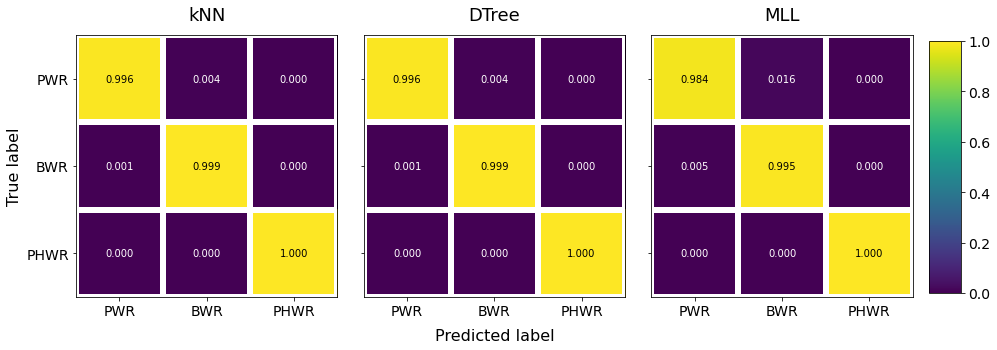

In [130]:
fig = plot_cm(knn, dtr, mll)
sv_fig = './plots/confusion_matrix_nuc29_err01.png'
fig.savefig(sv_fig, bbox_inches='tight', transparent=True)

### nuc29, 10% error case

In [131]:
mll = pd.read_csv(mll_nuc + 'nuc29/Job2_unc0.1/Job2_unc0.1.csv')
knn = pd.read_csv(learn_nuc + 'rand_err/reactor_knn_tset1.0_nuc29_err10_random_error.csv')
dtr = pd.read_csv(learn_nuc + 'rand_err/reactor_dtree_tset1.0_nuc29_err10_random_error.csv')

<Figure size 432x288 with 0 Axes>

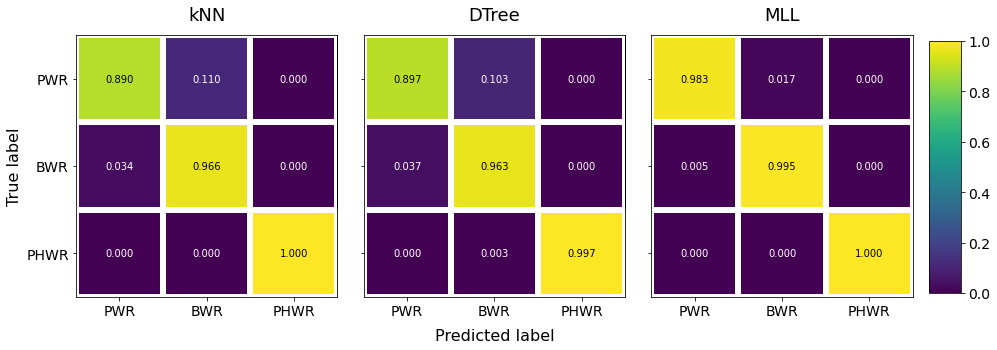

In [133]:
plot_cm(knn, dtr, mll)
sv_fig = './plots/confusion_matrix_nuc29_err10.png'
fig.savefig(sv_fig, bbox_inches='tight', transparent=True)

### act32 case

In [67]:
mll_a32 = pd.read_csv(mll_gam + 'act32/Job0_unc0.05/Job0_unc0.05.csv')
knn_a32 = pd.read_csv(learn_gam + 'test_0.067_only/act32/reactor_knn_tset1.0_act32_mimic_mll.csv')
dtr_a32 = pd.read_csv(learn_gam + 'test_0.067_only/act32/reactor_dtree_tset1.0_act32_mimic_mll.csv')

<Figure size 432x288 with 0 Axes>

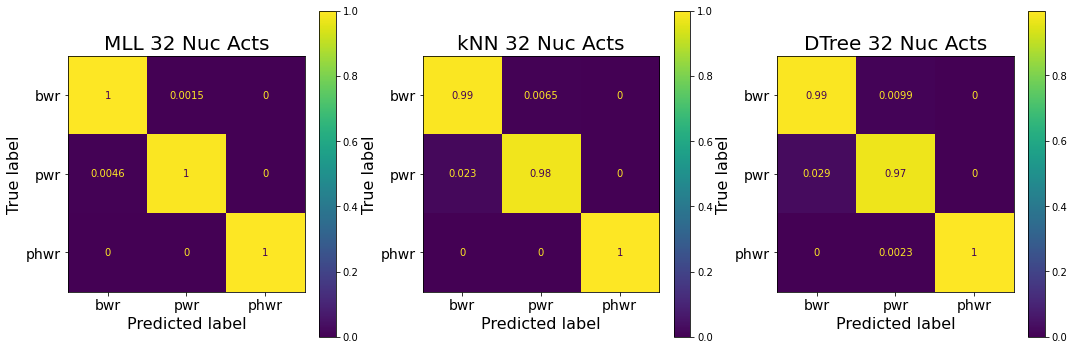

In [70]:
plot_cm([mll_cm, knn_cm, dtr_cm], ' 32 Nuc Acts')

### lab HPGe (d1) n31 case

In [72]:
mll_n31 = pd.read_csv(mll_gam + 'd1_n31/Job1_unc0.0/Job1_unc0.0.csv')
knn_n31 = pd.read_csv(learn_gam + 'test_0.067_only/n31/reactor_knn_tset1.0_d1_hpge_mimic_mll.csv')
dtr_n31 = pd.read_csv(learn_gam + 'test_0.067_only/n31/reactor_dtree_tset1.0_d1_hpge_mimic_mll.csv')

<Figure size 432x288 with 0 Axes>

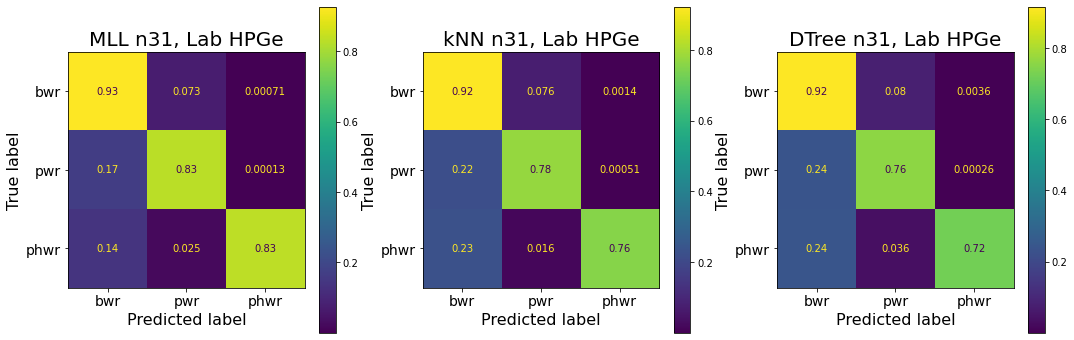

In [74]:
plot_cm([mll_cm, knn_cm, dtr_cm], ' n31, Lab HPGe')

### lab HPGe (d1) auto case

In [76]:
mll_auto = pd.read_csv(mll_gam + 'd1_auto/Job1_unc0.0/Job1_unc0.0.csv')
knn_auto = pd.read_csv(learn_gam + 'test_0.067_only/auto/reactor_knn_tset1.0_d1_hpge_mimic_mll.csv')
dtr_auto = pd.read_csv(learn_gam + 'test_0.067_only/auto/reactor_dtree_tset1.0_d1_hpge_mimic_mll.csv')

<Figure size 432x288 with 0 Axes>

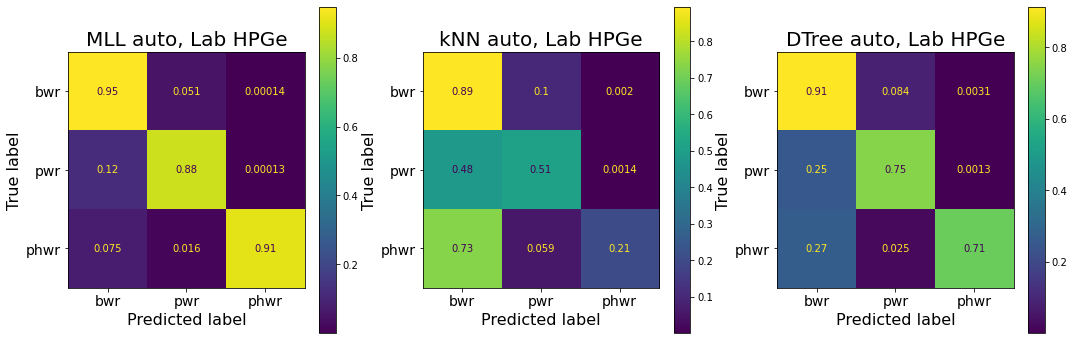

In [78]:
plot_cm([mll_cm, knn_cm, dtr_cm], ' auto, Lab HPGe')